Limits Generator

In [1]:
#% pip install openpyxl
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df
from utilities_plotting import plot_scatter, plot_capability, plot_simple_limits
from utilities_widgets import position_chart, widget_selector, widget_int_entry
import ipywidgets as widgets
from ipywidgets import HBox
import _db_tools as db
##Widgets creation
means_calculation = widget_selector(options=['Global means', 'Per position means'], description='Means algorithm', tooltips=['Calculate global means for each limit', 'Calculate means for each position'])
auto_position = widgets.Checkbox(value=False, description='Auto position', layout={'width': '200px'})
mean_slider = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.0005, readout_format='.3f', description='Y-axis mean')
range_slider = widgets.IntSlider(value=5, min=1, max=10, step=1, description='Y-axis zoom')

Database *input.db* found in: c:\Users\lucio\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\database\input.db
Database *output.db* found in: c:\Users\lucio\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\database\output.db


In [2]:
##Database access
table_list = consult_database("input.db", verbose=False)
default_measurements = consult_database("input.db", verbose=False, filter=glob.tooling+"_measurements_2")[-1]
default_limits = consult_database("input.db", verbose=False, filter=glob.tooling+"_limits_2")[-1]
tables = widgets.SelectMultiple(options=table_list, value=(default_measurements, default_limits), description='input db', rows=10, layout={'width': '600px'})

In [3]:
##Data extraction
print('Select the tables to load with "CTRL" or "SHIFT" pressed:')
display(tables)
MEAS = retrieve_data("input.db", next((string for string in tables.value if "measurements" in string), None))
LIMITS = retrieve_data("input.db", next((string for string in tables.value if "limits" in string), None))
if MEAS is None or MEAS.empty or LIMITS is None or LIMITS.empty:
    print("WARNING: Some data might not be correctly retrieved. Check the selected tables")

Select the tables to load with "CTRL" or "SHIFT" pressed:


SelectMultiple(description='input db', index=(4, 2), layout=Layout(width='600px'), options=('TOP_PASSAT_B9_lim…

Table *VA_007_measurements_2023y_12m_21d_14h_05m_01s* retrieved succesfully.
Table *VA_007_limits_2023y_12m_21d_14h_05m_01s* retrieved succesfully.


In [4]:
##Mean dataframe creation
display(means_calculation)
if means_calculation.value == 'Global means':
    means_df = mean_calculator(MEAS) #Global means version
elif means_calculation.value == 'Per position means':
    means_df = mean_calculator(MEAS, glob.lenses_per_nest) #Per position means version
means_df_format = rename_index(means_df)
means_df_format

ToggleButtons(description='Means algorithm', options=('Global means', 'Per position means'), tooltips=('Calcul…

,mean
Guia_Luz_Blanco_FB1_X,0.325980
Guia_Luz_Blanco_FB1_Y,0.348256
Guia_Luz_Blanco_FB2_X,0.325980
Guia_Luz_Blanco_FB2_Y,0.348256
Guia_Luz_Blanco_FB3_X,0.325980
Guia_Luz_Blanco_FB3_Y,0.348256
Guia_Luz_Blanco_FB4_X,0.325980
Guia_Luz_Blanco_FB4_Y,0.348256
Guia_Luz_Blanco_FB5_X,0.325980
Guia_Luz_Blanco_FB5_Y,0.348256


In [5]:
## Rearanged limits dataframe calculation
new_limits = limits_generator(means_df)
limits_format = rename_index(new_limits)
print("Adjusted limits")
limits_format

Adjusted limits


,LO_LIMIT,HI_LIMIT
Guia_Luz_Blanco_FB1_X,0.313480,0.338480
Guia_Luz_Blanco_FB1_Y,0.331756,0.364756
Guia_Luz_Blanco_FB2_X,0.313480,0.338480
Guia_Luz_Blanco_FB2_Y,0.331756,0.364756
Guia_Luz_Blanco_FB3_X,0.313480,0.338480
Guia_Luz_Blanco_FB3_Y,0.331756,0.364756
Guia_Luz_Blanco_FB4_X,0.313480,0.338480
Guia_Luz_Blanco_FB4_Y,0.331756,0.364756
Guia_Luz_Blanco_FB5_X,0.313480,0.338480
Guia_Luz_Blanco_FB5_Y,0.331756,0.364756


In [6]:
##Data review
MEAS_format = rename_index(MEAS)
new_column_names = {old_col: f"test: {i+1}" for i, old_col in enumerate(MEAS_format.columns)}
MEAS_format.rename(columns=new_column_names, inplace=True)
output = pd.concat([MEAS_format, limits_format], axis=1) #Concatenates the measures and limits
output

,test: 1,test: 2,test: 3,test: 4,test: 5,test: 6,test: 7,test: 8,test: 9,test: 10,...,test: 23,test: 24,test: 25,test: 26,test: 27,test: 28,test: 29,test: 30,LO_LIMIT,HI_LIMIT
Guia_Luz_Blanco_FB1_X,0.3226,0.3225,0.3225,0.3225,0.3223,0.3223,0.3223,0.3221,0.3222,0.3222,...,0.3222,0.3221,0.3221,0.3222,0.3222,0.3221,0.3221,0.3222,0.313480,0.338480
Guia_Luz_Blanco_FB1_Y,0.3457,0.3455,0.3455,0.3455,0.3454,0.3454,0.3454,0.3451,0.3452,0.3452,...,0.3452,0.3452,0.3452,0.3452,0.3452,0.3452,0.3452,0.3452,0.331756,0.364756
Guia_Luz_Blanco_FB2_X,0.3274,0.3273,0.3272,0.3272,0.3271,0.3272,0.3271,0.3270,0.3270,0.3270,...,0.3268,0.3268,0.3268,0.3267,0.3269,0.3268,0.3268,0.3268,0.313480,0.338480
Guia_Luz_Blanco_FB2_Y,0.3490,0.3490,0.3489,0.3489,0.3489,0.3489,0.3488,0.3487,0.3487,0.3487,...,0.3486,0.3485,0.3485,0.3485,0.3486,0.3485,0.3485,0.3485,0.331756,0.364756
Guia_Luz_Blanco_FB3_X,0.3239,0.3239,0.3238,0.3238,0.3238,0.3238,0.3237,0.3236,0.3235,0.3237,...,0.3236,0.3236,0.3237,0.3237,0.3236,0.3236,0.3236,0.3236,0.313480,0.338480
Guia_Luz_Blanco_FB3_Y,0.3450,0.3450,0.3449,0.3449,0.3449,0.3449,0.3448,0.3447,0.3447,0.3448,...,0.3447,0.3447,0.3448,0.3448,0.3447,0.3447,0.3447,0.3447,0.331756,0.364756
Guia_Luz_Blanco_FB4_X,0.3268,0.3268,0.3267,0.3267,0.3268,0.3266,0.3267,0.3266,0.3266,0.3265,...,0.3265,0.3264,0.3264,0.3264,0.3264,0.3263,0.3264,0.3263,0.313480,0.338480
Guia_Luz_Blanco_FB4_Y,0.3502,0.3501,0.3501,0.3501,0.3501,0.3500,0.3500,0.3500,0.3500,0.3499,...,0.3498,0.3498,0.3498,0.3498,0.3497,0.3497,0.3498,0.3497,0.331756,0.364756
Guia_Luz_Blanco_FB5_X,0.3285,0.3284,0.3284,0.3283,0.3284,0.3283,0.3284,0.3282,0.3282,0.3282,...,0.3281,0.3280,0.3280,0.3280,0.3280,0.3280,0.3280,0.3280,0.313480,0.338480
Guia_Luz_Blanco_FB5_Y,0.3510,0.3508,0.3508,0.3508,0.3508,0.3508,0.3508,0.3507,0.3507,0.3506,...,0.3505,0.3505,0.3505,0.3504,0.3505,0.3504,0.3505,0.3504,0.331756,0.364756


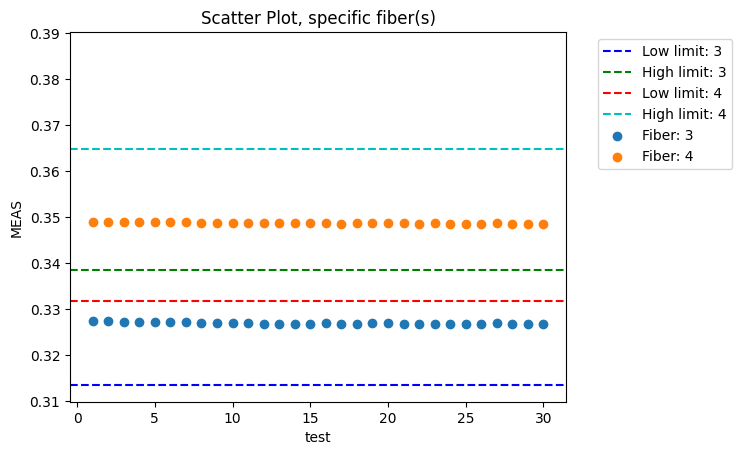

In [12]:
##Specific fibers visualization
yrange = position_chart(mean_slider, range_slider, auto_position_flag=auto_position.value)
display(HBox([auto_position, mean_slider, range_slider]))
plot_scatter(MEAS, title='Scatter Plot, specific fiber(s)', xlabel='test', ylabel='MEAS', limits=new_limits, filter=[3, 4], yrange=yrange)

In [8]:
##Data export and limit file generation
name = glob.tooling + "_" + get_date() + ".xlsx"
confirmation = input("Do you want to export the data to a new Target.xlsx file and generate a new limits ini file? (y/n): ").strip().lower()
if confirmation == 'y':
    output_filepath = os.path.join(os.path.abspath("../a2_output"), name)
    output.to_excel(output_filepath, index=True, header=True)
    #os.startfile('../a2_output/Target_with_limits.xlsx')
    ini_generator(new_limits, glob.lenses_per_nest, glob.nests_number)
    print(f'Data exported inside: {output_filepath}')
    print(f'Limits generated at: {os.path.split(output_filepath)[0]}')
else:
    print("Operation canceled.")

Operation canceled.


In [9]:
##Update of the database
name = re.sub(r'\W', '_', glob.tooling + "_" + get_date()) + "_limits&corrected"
confirmation = input("Do you want to export the new limits to your database (y/n): ").strip().lower()
if confirmation == 'y':
    prepare_database("input.db", new_limits, name) #Store a df for the limits inside the database of the project
    limits_file = rename_limits_table("output.db", name)
    print("Limit files renamed for clarity.")
    consult_database("input.db", verbose=True)
else:
    print("Operation canceled.")

Operation canceled.
